In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [43]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df_org = pd.read_csv("../survey_cleaned.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (45,54,59,72,171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Opis skupa:
--

In [4]:
df_org.describe()

,ID,ROLE,ROLESPECCL,COUNTRYCL,PHYS,ENGTECH,LIFE,MED,SOCEC,LAW,...,LANG4,LANG5,LANG6,LANG7,LANGOTHCL,LANGSPECCL,DEVELOPCL,OPENACC,OPENSCI,LANGUAGE
count,20663,20663,1525,20608,2644,3838,5246,3879,6465,520,...,880,157,491,245,116,116,12047,19013,19157,20663
unique,20663,8,475,151,1,1,1,1,1,1,...,5,4,5,5,1,93,9567,3,3,7
top,c17cce1dd33e5cdb0c9bb8adf2f075e4,Professor / Associate professor / Assistant pr...,researcher,United States,Physical Sciences,Engineering & Technology,Life Sciences,Medicine,Social Sciences & Economics,Law,...,Latindex,Red de Repositorios Latinamericanos,VKontakte,Science Index,(and also) others,ProdINRA,Open access,Yes,Yes,English
freq,1,8610,216,3439,2644,3838,5246,3879,6465,520,...,454,79,152,81,116,13,364,16323,15506,17785


Atributi:
--

In [5]:
# Odbacivanje atributa koji nisu relevantni
df_org = \
df_org.drop(['LANG1', 'LANG2', 'LANG3', 'LANG4', 
            'LANG5', 'LANG6', 'LANG7', 'LANGOTHCL', 'LANGSPECCL',
            'LANGUAGE', 'OPENACC', 'OPENSCI','ID', 'DEVELOPCL'], axis=1)  #, 'COUNTRYCL'

In [6]:
num_inst = df_org.shape[0]
print(f'Broj instanci {num_inst}\nBroj atributa {df_org.shape[1]}\n')


Broj instanci 20663
Broj atributa 164



In [7]:
# Analiza atributa:

# Atributi koje treba transformisati u dummy promenljive
dummy_targets = []
# Atributi koje treba transformisati u binarne (0, 1)
binary_targets = []
# Atributi koji sadrze "open text" odgovor
open_attrs = []


val_cnt = []
for attr in df_org.columns:
    val_cnt.append(df_org[attr].unique().shape[0])
    
    if str(attr) != 'ROLE' and str(attr).find('SPECCL') < 0 and str(attr) != 'PUBYEAR': 
        # ako atribut sadrzi vise od 2 razlicite vrednosti, bice transformisan u dummy attr za svaku vrednost
        if df_org[attr].unique().shape[0] != 2:
            dummy_targets.append(attr)
        else:
        # ako ima samo 2 razlicite vrednosti, atribut transformisati (nan, vrednost) -> (nan, 1)
            binary_targets.append(attr)
    # izdvajanje open answer odgovore
    if str(attr).find('SPECCL') != -1:
        open_attrs.append(attr)
                
# pd.DataFrame(val_cnt, df_org.columns, columns=['Broj razlicitih vrednosti'])

In [8]:
num_attr = df_org.shape[1]
# df_org.sample(5)

* Ciljna promenljiva za klasifikaciju bice: ROLE

In [9]:
def analyze_class(df):
    all_roles = df_org['ROLE']
    roles = df_org['ROLE'].unique()
    n_classes = roles.shape[0]
    
    print(f'Broj razlicitih klasa (attribut ROLE): {n_classes}')
    
    class_cnt = []
    for c in roles:
        class_cnt.append(np.sum(all_roles == c))
        
    print(pd.DataFrame(class_cnt, roles))
    
    return all_roles, roles, n_classes

Klase:
--


Pretprocesiranje:
-- 
- parsiranje open ('SPECCL') polja

- ROLE -> broj
- PUBYEAR -> ordinal (u dummyju zbog i havent)
- binarizacija 

Parisranje open polja:
--

In [10]:
def print_values_cnt(df, attr):
    helper_df = df[attr].value_counts()
    print(helper_df.head(5))
    

In [11]:
# izvlacenje vrednosti open polja koja je najfrekventnija kako bi bilo napravljeno novo polje
def get_most_freq(df, attr):
    helper_df = df[attr].value_counts()
    max_cnt_val = helper_df.idxmax()
    return max_cnt_val
    

In [12]:
new_class = get_most_freq(df_org, 'ROLESPECCL')
# print(f'Treba dodati jos jednu vrednost u klasu: {new_class}')

Dodavanje jos jedne klase:

In [13]:

df_org.loc[df_org['ROLESPECCL'] == new_class, ['ROLE']] = new_class

In [14]:
all_roles, roles, n_classes = analyze_class(df_org)

Broj razlicitih klasa (attribut ROLE): 9
                                                       0
Bachelor/Master student                             1754
Professor / Associate professor / Assistant pro...  8600
PhD student                                         3969
Postdoc                                             2310
Other                                               1421
Industry / Government                                677
Publisher                                            199
Librarian                                           1517
researcher                                           216


Enkodiranje klasa -> broj:

In [15]:
le = LabelEncoder()

le.fit(df_org['ROLE'])

df_org['ROLE'] = le.transform(df_org['ROLE'])

changed_roles = df_org['ROLE']

Dodavanje kolona:
---
* Ako je broj pojavljivanja najbrojnije vrednosti iz other polja veca od 10% * broj_popunjenih_other_polja, <br>
nova kolona ce biti generisana sa tom vrednoscu 

In [16]:
new_cols = []
def extract_column(data, attr, percentage):
    # broj ljudi koji su popunili kolonu
    attr_cnt = data[attr].count()
    
    # indeks kolone
    idx = data.columns.get_loc(attr)
    
    # najbrojnija vrednost
    max_cnt_val = get_most_freq(data, attr)
    
    # maks broj pojavljivanja
    max_cnt = data[attr].value_counts().iloc[0]
    
    if max_cnt/attr_cnt*1.0 > percentage:
        print(f'About to extract column for {attr}')
        print(f'\t{max_cnt}, {max_cnt_val}, {max_cnt/attr_cnt*1.0}')
        new_cols.append(str(attr)+'_manual')
        data = insert_new_column(data, attr, max_cnt_val, idx)
        
    return data

In [17]:
def insert_new_column(data, colname, value, index):
    data.insert(index, str(colname)+'_manual', np.full(data.shape[0], np.nan))
    
    sc_colname = colname.replace('SPECCL', 'OTHCL')
    
    print(data[sc_colname].unique())

    data.loc[data[colname] == value, [str(colname)+'_manual']] = value
    
    # Ako smo ubacili novu kolonu za neko polje, vrednost kolone koja opisuje da je odgovoreno na odgovarajuce 
    # open text pitanje treba da bude postovljena na nan
    data.loc[data[colname] == value, [sc_colname]] = np.nan
    return data

In [18]:
for col in open_attrs:
    if str(col) != 'ROLESPECCL':
        df = extract_column(df_org, col, 0.1)

About to extract column for ACCESSSPECCL
	366, Academia.edu, 0.12478690760313672
[nan '(and also) others']
About to extract column for NOTESPECCL
	593, Dropbox, 0.16751412429378532
[nan '(and also) others']
About to extract column for REFSPECCL
	438, BibTeX, 0.1931216931216931
[nan '(and also) others']
About to extract column for SHAREPUBSPECCL
	834, Academia.edu, 0.28099730458221023
[nan '(and also) others']
About to extract column for DATASPECCL
	444, Dropbox, 0.19830281375614114
[nan '(and also) others']
About to extract column for TELLSPECCL
	597, Facebook, 0.20368474923234392
[nan '(and also) others']
About to extract column for RESPROFSPECCL
	400, LinkedIn, 0.3228410008071025
[nan '(and also) others']
About to extract column for PRSPECCL
	120, colleagues, 0.24242424242424243
[nan '(and also) others']
About to extract column for IMPACTSPECCL
	500, Google Scholar, 0.3834355828220859
[nan '(and also) others']


In [19]:
df[open_attrs + new_cols].sample(10)

,ROLESPECCL,SEARCHSPECCL,ACCESSSPECCL,ALERTSPECCL,READSPECCL,ANALYZSPECCL,NOTESPECCL,WRITESPECCL,REFSPECCL,SHAREPUBSPECCL,...,IMPACTSPECCL,ACCESSSPECCL_manual,NOTESPECCL_manual,REFSPECCL_manual,SHAREPUBSPECCL_manual,DATASPECCL_manual,TELLSPECCL_manual,RESPROFSPECCL_manual,PRSPECCL_manual,IMPACTSPECCL_manual
2881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15739,NaN,NaN,NaN,NaN,NaN,G Power,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20517,NaN,"Google Scholar,websites of researchers",NaN,NaN,hardcopy,"own code,C/C++,Fortran,Mathematica","Dropbox,SurfDrive",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8260,NaN,NaN,NaN,NaN,NaN,NaN,Dropbox,NaN,NaN,NaN,...,NaN,NaN,Dropbox,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19938,NaN,NaN,NaN,NaN,NaN,NaN,Pages,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Isparsirana su sva open polja, dodate klase/kolone gde treba.<br>
Treba izbaciti sve atribute koji nisu relevantni.

In [20]:
# odbacujemo open atribute s obzirom da su isparsirane i njihove vrednosti izvucene
df = df.drop(open_attrs, axis=1)

print('Nakon pretprocesiranja free text polja, data frame ima oblik:')
df.sample(10)

Nakon pretprocesiranja free text polja, data frame ima oblik:


,ROLE,COUNTRYCL,PHYS,ENGTECH,LIFE,MED,SOCEC,LAW,ARTHUM,PUBYEAR,...,PRSPECCL_manual,JCRIFIMP,ALTMETRIC,SCOPID,IMPSTOR,PLOSALM,WOSIMP,HARZPOP,IMPACTOTHCL,IMPACTSPECCL_manual
165,6,United States,NaN,NaN,NaN,NaN,NaN,NaN,Arts & Humanities,2001-2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15665,1,India,NaN,Engineering & Technology,NaN,NaN,NaN,NaN,NaN,2011-2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13986,6,United States,NaN,NaN,NaN,Medicine,NaN,NaN,NaN,2001-2005,...,NaN,JCR (impact factors),NaN,Scopus,NaN,NaN,Web of Science,NaN,NaN,NaN
10860,3,Finland,Physical Sciences,NaN,NaN,NaN,NaN,NaN,NaN,1991-2000,...,NaN,NaN,NaN,Scopus,NaN,NaN,Web of Science,NaN,NaN,NaN
16199,5,Spain,NaN,NaN,NaN,Medicine,NaN,NaN,NaN,2001-2005,...,NaN,JCR (impact factors),NaN,NaN,NaN,NaN,Web of Science,NaN,NaN,NaN
11175,6,Australia,NaN,NaN,Life Sciences,Medicine,NaN,NaN,NaN,2011-2016,...,NaN,JCR (impact factors),NaN,Scopus,NaN,NaN,Web of Science,NaN,NaN,NaN
18333,4,Netherlands,NaN,NaN,NaN,Medicine,NaN,NaN,NaN,2011-2016,...,NaN,NaN,NaN,Scopus,NaN,NaN,NaN,NaN,NaN,NaN
13395,1,Canada,Physical Sciences,NaN,NaN,NaN,NaN,NaN,NaN,before 1991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,5,Kenya,NaN,NaN,Life Sciences,NaN,NaN,NaN,NaN,2006-2010,...,NaN,JCR (impact factors),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13609,0,Saudi Arabia,NaN,Engineering & Technology,NaN,NaN,NaN,NaN,NaN,2011-2016,...,NaN,NaN,NaN,Scopus,NaN,NaN,Web of Science,NaN,NaN,NaN


In [21]:
df_SPSS = df

Dummy encoding:
---

In [22]:
df.head()

,ROLE,COUNTRYCL,PHYS,ENGTECH,LIFE,MED,SOCEC,LAW,ARTHUM,PUBYEAR,...,PRSPECCL_manual,JCRIFIMP,ALTMETRIC,SCOPID,IMPSTOR,PLOSALM,WOSIMP,HARZPOP,IMPACTOTHCL,IMPACTSPECCL_manual
0,0,Germany,NaN,NaN,NaN,NaN,Social Sciences & Economics,NaN,NaN,I haven't published (yet),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,Spain,NaN,NaN,NaN,NaN,Social Sciences & Economics,NaN,NaN,2006-2010,...,NaN,JCR (impact factors),NaN,Scopus,NaN,NaN,NaN,NaN,NaN,NaN
2,6,Hungary,NaN,NaN,NaN,NaN,NaN,NaN,Arts & Humanities,1991-2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,Brazil,NaN,Engineering & Technology,NaN,NaN,Social Sciences & Economics,NaN,NaN,1991-2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Norway,Physical Sciences,NaN,NaN,NaN,Social Sciences & Economics,NaN,NaN,1991-2000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Enkodiranje u dummies
df = pd.get_dummies(df, columns=dummy_targets)
df = pd.get_dummies(df, columns=new_cols)
df.sample(10)

,ROLE,PHYS,ENGTECH,LIFE,MED,SOCEC,LAW,ARTHUM,PUBYEAR,GSCHOLSEARCH,...,COUNTRYCL_Zimbabwe,ACCESSSPECCL_manual_Academia.edu,NOTESPECCL_manual_Dropbox,REFSPECCL_manual_BibTeX,SHAREPUBSPECCL_manual_Academia.edu,DATASPECCL_manual_Dropbox,TELLSPECCL_manual_Facebook,RESPROFSPECCL_manual_LinkedIn,PRSPECCL_manual_colleagues,IMPACTSPECCL_manual_Google Scholar
15126,6,NaN,NaN,NaN,NaN,Social Sciences & Economics,NaN,NaN,1991-2000,Google Scholar,...,0,0,0,0,0,0,0,0,1,1
19326,4,NaN,NaN,NaN,NaN,NaN,NaN,Arts & Humanities,I haven't published (yet),Google Scholar,...,0,1,0,0,0,0,1,0,0,0
15980,4,NaN,Engineering & Technology,Life Sciences,NaN,NaN,NaN,NaN,2011-2016,Google Scholar,...,0,0,0,0,0,0,0,0,0,0
16317,4,NaN,Engineering & Technology,NaN,NaN,NaN,NaN,NaN,2011-2016,Google Scholar,...,0,0,0,0,0,0,0,0,0,0
12157,2,NaN,Engineering & Technology,Life Sciences,NaN,NaN,Law,NaN,2011-2016,NaN,...,0,0,0,0,0,0,0,0,0,0
2188,5,Physical Sciences,NaN,NaN,NaN,NaN,NaN,NaN,2006-2010,Google Scholar,...,0,0,0,0,0,0,0,0,0,0
11876,6,NaN,NaN,Life Sciences,NaN,NaN,NaN,NaN,before 1991,Google Scholar,...,0,0,0,0,1,0,1,0,0,0
2892,4,NaN,NaN,NaN,NaN,Social Sciences & Economics,NaN,NaN,I haven't published (yet),Google Scholar,...,0,0,0,0,0,0,0,0,0,0
3747,6,Physical Sciences,NaN,NaN,NaN,NaN,NaN,NaN,1991-2000,NaN,...,0,0,0,0,0,0,0,0,0,0
7199,5,NaN,NaN,NaN,Medicine,NaN,NaN,NaN,2006-2010,Google Scholar,...,0,0,0,0,0,0,0,0,0,0


PUBYEAR -> ordinal:

In [24]:
pubyear_change = {
    'before 1991': 1,
    '1991-2000': 2,
    '2001-2005': 3,
    '2006-2010': 4,
    '2011-2016': 5,
    "I haven't published (yet)": np.nan
}

df['PUBYEAR'] = df['PUBYEAR'].replace(pubyear_change)



In [25]:
df = pd.get_dummies(df, columns=['PUBYEAR'])

Binarizacija:
---

In [26]:
df = pd.get_dummies(df, columns=binary_targets)

In [27]:
# df = pd.get_dummies(df, columns=new_cols)
df.sample(10)

,ROLE,COUNTRYCL_Albania,COUNTRYCL_Algeria,COUNTRYCL_Argentina,COUNTRYCL_Armenia,COUNTRYCL_Australia,COUNTRYCL_Austria,COUNTRYCL_Azerbaijan,COUNTRYCL_Bahamas,COUNTRYCL_Bahrain,...,KARMA_Academic Karma,PROTHCL_(and also) others,JCRIFIMP_JCR (impact factors),ALTMETRIC_Altmetric,SCOPID_Scopus,IMPSTOR_ImpactStory,PLOSALM_PLoS article level metrics,WOSIMP_Web of Science,HARZPOP_Harzing Publish or Perish,IMPACTOTHCL_(and also) others
15359,5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19397,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3752,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2106,2,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
9837,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
9107,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10300,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9725,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
17859,6,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
17194,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
cols_unique_vals = []
for col in df.columns:
    help_list = map(lambda x: str(x), df[col].unique().tolist())
    cols_unique_vals.append(", ".join(help_list))
    
    # cols_unique_vals.append(map(df[col].unique().tolist()))

# print(cols_unique_vals)
# pd.DataFrame(cols_unique_vals, df.columns)

In [29]:
print('Nakon pretprocesiranja podaci:')
df.sample(10)

Nakon pretprocesiranja podaci:


,ROLE,COUNTRYCL_Albania,COUNTRYCL_Algeria,COUNTRYCL_Argentina,COUNTRYCL_Armenia,COUNTRYCL_Australia,COUNTRYCL_Austria,COUNTRYCL_Azerbaijan,COUNTRYCL_Bahamas,COUNTRYCL_Bahrain,...,KARMA_Academic Karma,PROTHCL_(and also) others,JCRIFIMP_JCR (impact factors),ALTMETRIC_Altmetric,SCOPID_Scopus,IMPSTOR_ImpactStory,PLOSALM_PLoS article level metrics,WOSIMP_Web of Science,HARZPOP_Harzing Publish or Perish,IMPACTOTHCL_(and also) others
597,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12333,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12598,6,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1664,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5944,3,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19368,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17624,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13145,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6971,4,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7389,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [30]:
df.describe()

,ROLE,COUNTRYCL_Albania,COUNTRYCL_Algeria,COUNTRYCL_Argentina,COUNTRYCL_Armenia,COUNTRYCL_Australia,COUNTRYCL_Austria,COUNTRYCL_Azerbaijan,COUNTRYCL_Bahamas,COUNTRYCL_Bahrain,...,KARMA_Academic Karma,PROTHCL_(and also) others,JCRIFIMP_JCR (impact factors),ALTMETRIC_Altmetric,SCOPID_Scopus,IMPSTOR_ImpactStory,PLOSALM_PLoS article level metrics,WOSIMP_Web of Science,HARZPOP_Harzing Publish or Perish,IMPACTOTHCL_(and also) others
count,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,...,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000
mean,4.361467,0.000145,0.001403,0.005711,0.000145,0.027392,0.004404,0.000145,0.001065,0.000048,...,0.007259,0.018148,0.326235,0.118279,0.274549,0.027295,0.058752,0.328945,0.029279,0.038910
std,1.978776,0.012049,0.037438,0.075355,0.012049,0.163227,0.066218,0.012049,0.032613,0.006957,...,0.084894,0.133491,0.468846,0.322946,0.446297,0.162946,0.235166,0.469841,0.168593,0.193385
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
df.to_csv ('survey_preprocessed.csv', index = None, header=True)

Priprema podataka za SPSS stabla:
---

In [ ]:
for (column, i) in enumerate(df_SPSS.columns):
    print(f'{column} -> {i}')

In [ ]:
def merge_columns(data, idx_start, idx_end, group_cnt):
    new_col_name = 'group_'+str(group_cnt)
    data.insert(len(data.columns), new_col_name, np.full(num_inst, np.nan))
    
    columns = []
    for i in range(idx_start, idx_end+1):
        colname = data.columns[i]
        
        values = []
        columns.append(colname)
        for val in list(data[colname].unique()):
            if str(val) != "nan":
                values.append(val)
        
#         print(f'{values}')
        
        for val in values:
#             print('\t'+str(val))
            data.loc[df[colname] == val, [new_col_name]] = val
    columns.append(new_col_name)
#     print(data[new_col_name].unique())
    return data

In [ ]:
df_help = merge_columns(df_SPSS, 2, 8, 1)
df_help['group_1'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 10, 17, 2)
df_help['group_2'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 18, 26, 3)
df_help['group_3'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 27, 34, 4)
df_help['group_4'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 35, 42, 5)
df_help['group_5'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 43, 50, 6)
df_help['group_6'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 50, 59, 7)
df_help['group_7'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 60, 67, 8)
df_help['group_8'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 68, 76, 9)
df_help['group_9'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 77, 85, 10)
df_help['group_10'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 86, 94, 11)
df_help['group_11'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 86, 94, 12)
df_help['group_12'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 95, 102, 13)
df_help['group_13'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 103, 110, 14)
df_help['group_14'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 111, 118, 15)
df_help['group_15'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 119, 127, 16)
df_help['group_16'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 128, 136, 17)
df_help['group_17'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 137, 145, 18)
df_help['group_18'].unique()

In [ ]:
df_help = merge_columns(df_SPSS, 146, 154, 19)
df_help['group_19'].unique()

In [ ]:
for col in df_help.columns:
    if col != "ROLE" and col != "PUBYEAR" and col != "COUNTRYCL" and str(col).find('group_') < 0:
        df_help = df_help.drop([col], axis=1)

In [ ]:
df_help.sample(10)

In [ ]:
df_help.to_csv ('survey_SPSS.csv', index = None, header=True)

In [44]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

from keras.engine.input_layer import Input
from keras.losses import mean_squared_error


In [45]:
def print_confusion_matrix(model_name, confusion_matrix, class_names, figsize = (12,10), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_facecolor('xkcd:salmon')
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./img/'+model_name+'_conf_mat.jpg', dpi=60)
#     return fig

In [46]:
X = df.drop('ROLE', axis = 1)
Y = df['ROLE']

In [47]:
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y = np_utils.to_categorical(Y)

In [48]:
print(Y)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [49]:
train_x, test_x, train_y, test_y = \
    train_test_split(X, Y, test_size=0.3, stratify=Y,
                   random_state=0)

input_dim = len(df.columns) - 1

NUM_CLASSES = 9

In [50]:
def dense_relu(units, alpha=0., bn=False, dropout=0.):
    def layer(x):
        x = Dense(units)(x)
        x = LeakyReLU(alpha=alpha)(x)
        if bn:
            x = BatchNormalization()(x)
        if dropout:
            x = Dropout(rate=dropout)(x)
        return x
    return layer
 
class AutoEncoder():
    def __init__(self, input_shape, encoder_units, z_unit, decoder_units, optimizer_lr=1e-3):
        self.input_shape = input_shape
        self.encoder_units = encoder_units
        self.decoder_units = decoder_units
        self.z_unit = z_unit
        input = Input((*self.input_shape,))
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.ae = Model(input, self.decoder(self.encoder(input)), name='autoencoder')
        
        optimizer = Adam(optimizer_lr)
        self.ae.compile(optimizer=optimizer, loss=mean_squared_error, metrics=['mse'])
        
    def build_encoder(self):
        input = x = Input(shape=(*self.input_shape,))

        for unit in self.encoder_units:
            x = dense_relu(unit, 0.2, True, 0)(x)

        z = Dense(self.z_unit, activation='linear', name='embedding')(x)

        return Model(input, z, name='encoder')

    def build_decoder(self):
        input = x = Input(shape=(self.z_unit,))

        for unit in self.decoder_units:
            x = dense_relu(unit,0.2,True,0)(x)

        out = Dense(*(self.input_shape), activation='linear')(x)

        return Model(input,out, name='decoder')

    def train(self, train_x, epochs=10, batch_size=64, callbacks=None):
        history = self.ae.fit(train_x, train_x, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=2)
        return history

    def encode_to_latent(self, x):
        return self.encoder.predict(x, batch_size=1)

class FullyConnected():
    def __init__(self, input_shape, no_classes, units, dropout_rate=0, optimizer_lr=1e-3):
        self.input_shape = input_shape
        self.no_classes = no_classes
        self.units = units
        self.dropout_rate = dropout_rate
        
        self.fc = self.build_model()

        optimizer = Adam(optimizer_lr)

        self.fc.compile(optimizer=optimizer, loss='categorical_crossentropy' if self.no_classes > 2
                        else 'binary_crossentropy', metrics=['accuracy'])

    def build_model(self):
        input = x = Input(shape=(*self.input_shape,))

        for unit in self.units:
            x = dense_relu(unit, alpha=0.1, bn=True, dropout=self.dropout_rate)(x)

        output = Dense(self.no_classes, activation='softmax' if self.no_classes > 2 else 'sigmoid')(x)

        return Model(input, output)

    def train(self, train_x, train_y, epochs=10, batch_size=64, validation_split=0, callbacks=None):
        history = self.fc.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                              callbacks=callbacks, verbose=2)
        
        return history

    def evaluate(self, test_x, test_y, batch_size=1):
        loss, metrics = self.fc.evaluate(test_x, test_y, batch_size=batch_size)

        return loss, metrics
    
    def predict(self, test_x):
        return self.fc.predict(test_x)

In [51]:
AE_LR = 1e-4
AE_EPOCHS = 200
AE_BATCH_SIZE = 128
AE_LATENT_DIM = 128
 
ae_structure = {
    'input_shape': (input_dim,),
    'encoder_units': (256,200,),
    'z_unit' : AE_LATENT_DIM,
    'decoder_units': (200,256,)
}
 
autoencoder = AutoEncoder(**ae_structure, optimizer_lr=AE_LR)

W0814 17:58:16.697561 140534187808576 deprecation.py:506] From /home/antic/.local/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/200
 - 4s - loss: 0.5402 - mean_squared_error: 0.5402
Epoch 2/200
 - 1s - loss: 0.1436 - mean_squared_error: 0.1436
Epoch 3/200
 - 1s - loss: 0.0810 - mean_squared_error: 0.0810
Epoch 4/200
 - 1s - loss: 0.0641 - mean_squared_error: 0.0641
Epoch 5/200
 - 1s - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 6/200
 - 1s - loss: 0.0477 - mean_squared_error: 0.0477
Epoch 7/200
 - 1s - loss: 0.0436 - mean_squared_error: 0.0436
Epoch 8/200
 - 1s - loss: 0.0413 - mean_squared_error: 0.0413
Epoch 9/200
 - 1s - loss: 0.0400 - mean_squared_error: 0.0400
Epoch 10/200
 - 1s - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 11/200
 - 1s - loss: 0.0385 - mean_squared_error: 0.0385
Epoch 12/200
 - 1s - loss: 0.0378 - mean_squared_error: 0.0378
Epoch 13/200
 - 1s - loss: 0.0371 - mean_squared_error: 0.0371
Epoch 14/200
 - 1s - loss: 0.0364 - mean_squared_error: 0.0364
Epoch 15/200
 - 1s - loss: 0.0357 - mean_squared_error: 0.0357
Epoch 16/200
 - 1s - loss: 0.0350 - mean_squared_error: 0.0350
E

Epoch 131/200
 - 1s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 132/200
 - 1s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 133/200
 - 1s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 134/200
 - 1s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 135/200
 - 1s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 136/200
 - 1s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 137/200
 - 1s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 138/200
 - 1s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 139/200
 - 1s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 140/200
 - 1s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 141/200
 - 1s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 142/200
 - 1s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 143/200
 - 1s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 144/200
 - 1s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 145/200
 - 1s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 146/200
 - 1s - loss: 0.0048 - mea

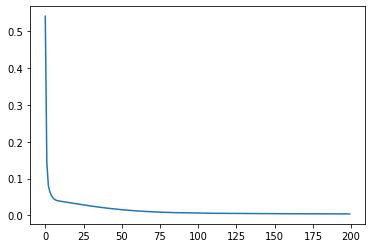

Encoded train shape: (14464, 128)
Encoded test shape: (6199, 128)


In [52]:
history = autoencoder.train(train_x, epochs=AE_EPOCHS, batch_size=AE_BATCH_SIZE)
 
plt.plot(np.arange(AE_EPOCHS), history.history['loss'])
plt.show()
#%%
encoded_train_x = autoencoder.encode_to_latent(train_x)
encoded_test_x = autoencoder.encode_to_latent(test_x)
print(f'Encoded train shape: {encoded_train_x.shape}\nEncoded test shape: {encoded_test_x.shape}')

In [53]:
F_LR = 1e-3
F_DROPOUT_RATE = 0.5
 
F_EPOCHS = 100
F_BATCH_SIZE = 128
 
F_structure = {
    'input_shape': (input_dim,),
    'no_classes' : NUM_CLASSES,
    'units': (128,64)
}
 
fc_full = FullyConnected(**F_structure, dropout_rate=F_DROPOUT_RATE, optimizer_lr=F_LR)
#%%
FL_LR = 1e-3
FL_DROPOUT_RATE = 0.5
 
FL_EPOCHS = 100
FL_BATCH_SIZE = 128
 
FL_structure = {
    'input_shape': (AE_LATENT_DIM,),
    'no_classes' : NUM_CLASSES,
    'units': (128,64)
}
fc_latent = FullyConnected(**FL_structure, dropout_rate=FL_DROPOUT_RATE, optimizer_lr=FL_LR)

W0814 18:01:01.025504 140534187808576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
fc_full_history = fc_full.train(train_x, train_y, epochs=F_EPOCHS, batch_size=F_BATCH_SIZE,
                                validation_split=0.2)
print(f'\nFully connected training on original features finished.\n')
fc_latent_histroy = fc_latent.train(encoded_train_x, train_y, epochs=FL_EPOCHS, batch_size=FL_BATCH_SIZE,
                                    validation_split=0.2)
print(f'\nFully connected training on encoded features finished.\n')
#%%
fc_loss, fc_acc = fc_full.evaluate(test_x, test_y, batch_size=32)
fc_l_loss, fc_l_acc = fc_latent.evaluate(encoded_test_x, test_y, batch_size=32)
print(f'Fully connected:\nacc: {fc_acc:.4f} - loss: {fc_loss:.4f}\n'
      f'Fully connected latent:\nacc: {fc_l_acc:.4f} - loss: {fc_l_loss:.4f}')

Train on 11571 samples, validate on 2893 samples
Epoch 1/100
 - 1s - loss: 2.4271 - acc: 0.2705 - val_loss: 1.4586 - val_acc: 0.5548
Epoch 2/100
 - 0s - loss: 1.7239 - acc: 0.4735 - val_loss: 1.3272 - val_acc: 0.5952
Epoch 3/100
 - 0s - loss: 1.4950 - acc: 0.5378 - val_loss: 1.2659 - val_acc: 0.5976
Epoch 4/100
 - 0s - loss: 1.4003 - acc: 0.5598 - val_loss: 1.2245 - val_acc: 0.6059
Epoch 5/100
 - 0s - loss: 1.3135 - acc: 0.5802 - val_loss: 1.2044 - val_acc: 0.6066
Epoch 6/100
 - 0s - loss: 1.2831 - acc: 0.5886 - val_loss: 1.1929 - val_acc: 0.6042
Epoch 7/100
 - 0s - loss: 1.2388 - acc: 0.5923 - val_loss: 1.1770 - val_acc: 0.6063
Epoch 8/100
 - 0s - loss: 1.2200 - acc: 0.6012 - val_loss: 1.1725 - val_acc: 0.6111
Epoch 9/100
 - 0s - loss: 1.1993 - acc: 0.6059 - val_loss: 1.1635 - val_acc: 0.6149
Epoch 10/100
 - 0s - loss: 1.1882 - acc: 0.6128 - val_loss: 1.1600 - val_acc: 0.6122
Epoch 11/100
 - 0s - loss: 1.1670 - acc: 0.6151 - val_loss: 1.1573 - val_acc: 0.6108
Epoch 12/100
 - 0s - loss

Epoch 97/100
 - 0s - loss: 0.8172 - acc: 0.7181 - val_loss: 1.2654 - val_acc: 0.6104
Epoch 98/100
 - 0s - loss: 0.8306 - acc: 0.7105 - val_loss: 1.2663 - val_acc: 0.6070
Epoch 99/100
 - 0s - loss: 0.8311 - acc: 0.7084 - val_loss: 1.2707 - val_acc: 0.6125
Epoch 100/100
 - 0s - loss: 0.8130 - acc: 0.7189 - val_loss: 1.2804 - val_acc: 0.6135

Fully connected training on original features finished.

Train on 11571 samples, validate on 2893 samples
Epoch 1/100
 - 1s - loss: 2.4617 - acc: 0.2486 - val_loss: 1.7206 - val_acc: 0.4895
Epoch 2/100
 - 0s - loss: 1.8381 - acc: 0.4517 - val_loss: 1.5749 - val_acc: 0.5289
Epoch 3/100
 - 0s - loss: 1.6637 - acc: 0.5016 - val_loss: 1.4679 - val_acc: 0.5558
Epoch 4/100
 - 0s - loss: 1.5774 - acc: 0.5197 - val_loss: 1.4085 - val_acc: 0.5638
Epoch 5/100
 - 0s - loss: 1.5194 - acc: 0.5358 - val_loss: 1.3829 - val_acc: 0.5700
Epoch 6/100
 - 0s - loss: 1.4680 - acc: 0.5376 - val_loss: 1.3310 - val_acc: 0.5755
Epoch 7/100
 - 0s - loss: 1.4350 - acc: 0.5503 -

Epoch 93/100
 - 0s - loss: 1.0793 - acc: 0.6315 - val_loss: 1.1728 - val_acc: 0.6084
Epoch 94/100
 - 0s - loss: 1.0695 - acc: 0.6338 - val_loss: 1.1744 - val_acc: 0.6059
Epoch 95/100
 - 0s - loss: 1.0726 - acc: 0.6332 - val_loss: 1.1702 - val_acc: 0.6053
Epoch 96/100
 - 0s - loss: 1.0761 - acc: 0.6325 - val_loss: 1.1632 - val_acc: 0.6091
Epoch 97/100
 - 0s - loss: 1.0711 - acc: 0.6336 - val_loss: 1.1650 - val_acc: 0.6135
Epoch 98/100
 - 0s - loss: 1.0787 - acc: 0.6268 - val_loss: 1.1653 - val_acc: 0.6129
Epoch 99/100
 - 0s - loss: 1.0642 - acc: 0.6364 - val_loss: 1.1645 - val_acc: 0.6059
Epoch 100/100
 - 0s - loss: 1.0603 - acc: 0.6393 - val_loss: 1.1813 - val_acc: 0.6091

Fully connected training on encoded features finished.

6199/6199 [==============================] - 0s 17us/step
Fully connected:
acc: 0.6224 - loss: 1.2568
Fully connected latent:
acc: 0.6159 - loss: 1.1670


In [55]:
pred_y = fc_full.predict(test_x)
matrix = metrics.confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))

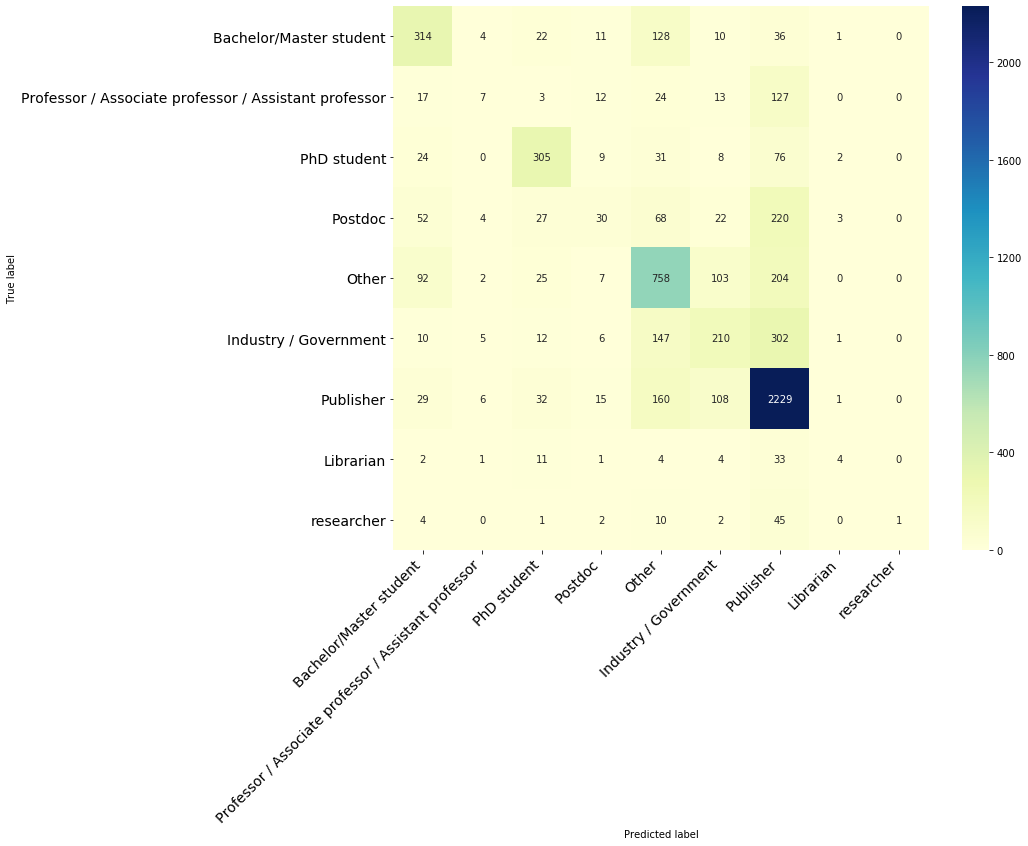

In [57]:
print_confusion_matrix('fully_connected', matrix, roles)

In [58]:
pred_y = fc_latent.predict(encoded_test_x)
matrix = metrics.confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))

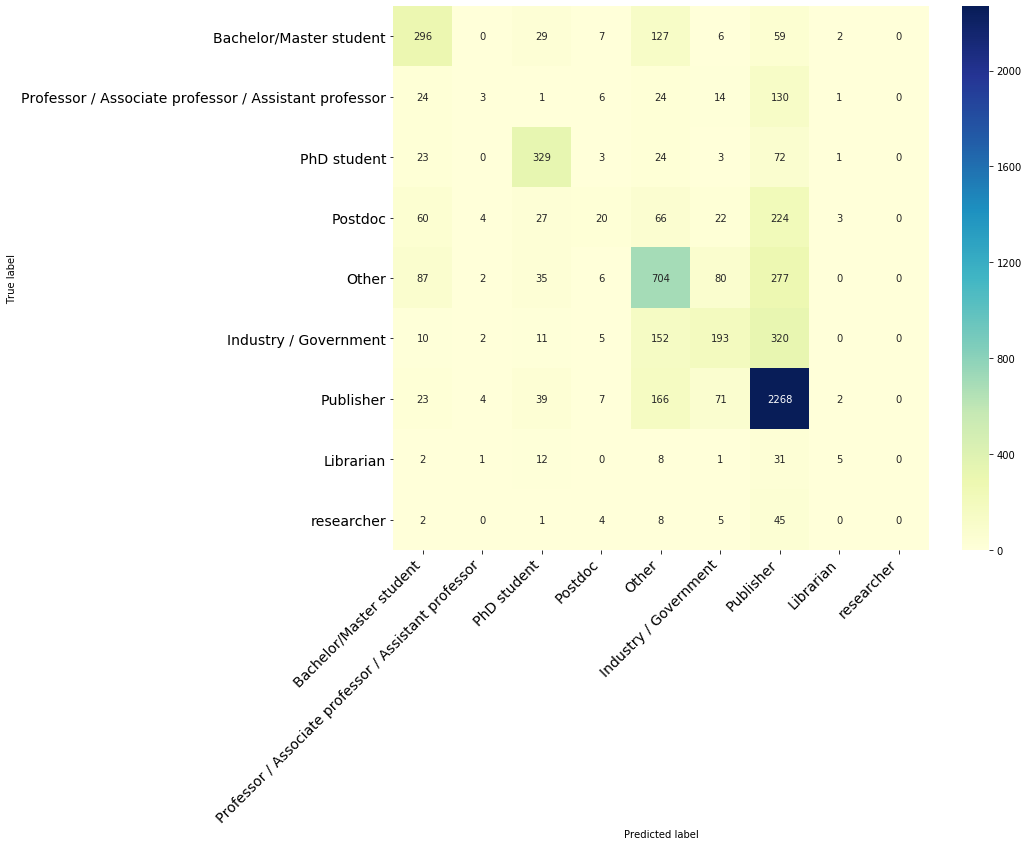

In [59]:
print_confusion_matrix('latent_fully', matrix, roles)